In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/NLP/SA_Word2Vec/data1

/content/drive/My Drive/NLP/SA_Word2Vec/data1


In [0]:
%matplotlib inline

# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

# numpy
import numpy as np

# classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# random, itertools, matplotlib
import random
import itertools
import matplotlib.pyplot as plt

In [0]:
import codecs
import re
import os    
from chardet import detect

# get file encoding type
def get_encoding_type(file):
    with open(file, 'rb') as f:
        rawdata = f.read()
    return detect(rawdata)['encoding']

if __name__ == '__main__':
  cnt = 0
  file= open('rt-polarity.pos', 'r', encoding = get_encoding_type('rt-polarity.pos'), errors='ignore')
  for line in file:
    line =  re.sub(r'[?|$|.|!]',r'',line + '\n')
    line = re.sub(r'[^a-zA-Z0-9 ]',r'',line)
    cnt += 1
  file.close()
  print(cnt)

In [0]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [0]:
sources = {
    'test-neg.txt':'TEST_NEG',
    'test-pos.txt':'TEST_POS', 
    'train-neg.txt':'TRAIN_NEG', 
    'train-pos.txt':'TRAIN_POS', 
}

sentences = LabeledLineSentence(sources)

In [0]:
sources = {
    'neg.txt':'TRAIN_NEG',
    'pos.txt':'TRAIN_POS'
}
sentences = LabeledLineSentence(sources)

In [0]:
model = Doc2Vec(min_count=5, window=8, size=100, sample=1e-4, negative=5, workers=4)
model.build_vocab(sentences.to_array())


In [0]:
model.train(sentences.sentences_perm(), total_examples=model.corpus_count, epochs=20)

In [0]:
model.most_similar('good')
model.docvecs['TRAIN_NEG_0']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


array([ 2.04540733e-02, -8.80355109e-03, -5.09346137e-03,  1.16899936e-02,
       -2.10139677e-02,  3.01842242e-02,  6.10662252e-03, -3.79141681e-02,
       -1.27900578e-02,  3.31926486e-03, -6.75066048e-03,  2.19130088e-02,
       -1.82115287e-02,  2.53737327e-02, -2.07704734e-02, -2.22784164e-03,
        1.49219343e-02,  5.91195794e-03, -9.98992287e-03,  2.94226035e-03,
        7.92274531e-03, -1.67980436e-02,  1.20890159e-02, -1.96036529e-02,
        1.13007491e-02, -1.19279115e-03,  2.10121414e-03, -7.21047400e-03,
       -4.84462781e-03, -6.58585690e-03, -1.07084531e-02,  1.81445684e-02,
        1.75379980e-02, -5.87582812e-02, -1.20109553e-03, -4.96167224e-04,
       -2.33428869e-02, -1.38338143e-02,  9.00478847e-03,  1.13128135e-02,
        1.17758010e-02,  1.24108437e-02, -1.34329489e-02, -3.01754717e-02,
       -9.48057231e-03, -1.88691018e-03,  5.32957958e-03, -2.07087267e-02,
        1.71805508e-02, -3.98663692e-02, -1.70975719e-02, -1.96625246e-03,
       -3.95156583e-03,  

In [0]:
model.save('./imdb.d2v')
model = Doc2Vec.load('./imdb.d2v')


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.zeros((10660, 100))
y = np.zeros(10660)
for i in range(5330):
   X[i] = model.docvecs['TRAIN_POS_' + str(i)]
   y[i] = 1
   X[5330+i] = model.docvecs['TRAIN_NEG_' + str(i)]
   y[i+5330] = 0

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.33, random_state=100)


In [0]:
X_train = np.zeros((25000, 100))
y_train = np.zeros(25000)
for i in range(12500):
    prefix_train_pos = 'TRAIN_POS_' + str(i)
    prefix_train_neg = 'TRAIN_NEG_' + str(i)
    X_train[i] = model.docvecs[prefix_train_pos]
    X_train[12500 + i] = model.docvecs[prefix_train_neg]
    y_train[i] = 1
    y_train[12500 + i] = 0

In [0]:
X_test = np.zeros((25000, 100))
y_test = np.zeros(25000)

for i in range(12500):
    prefix_test_pos = 'TEST_POS_' + str(i)
    prefix_test_neg = 'TEST_NEG_' + str(i)
    X_test[i] = model.docvecs[prefix_test_pos]
    X_test[12500 + i] = model.docvecs[prefix_test_neg]
    y_test[i] = 1
    y_test[12500 + i] = 0

In [0]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy 0.5497441728254691
Confusion matrix, without normalization


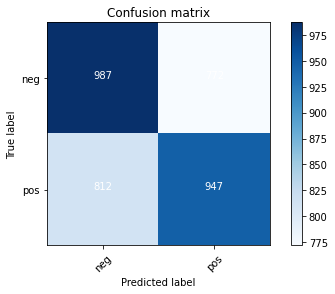

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print ('Accuracy', classifier.score(X_test, y_test))
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=['neg', 'pos'])

Accuracy 0.533826037521319
Confusion matrix, without normalization


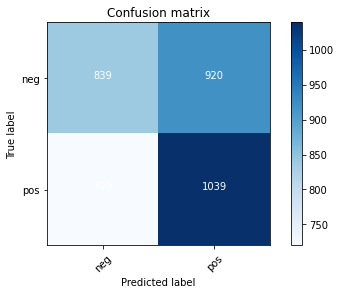

In [0]:
classifier = SVC()
classifier.fit(X_train, y_train)

print ('Accuracy', classifier.score(X_test, y_test))
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=['neg', 'pos'])